In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append("../src/")

In [3]:
#export
from nb_04 import *
torch.set_num_threads(2)

## ConvNet

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [6]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [7]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [8]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a Lambda layer that can take a basic function and convert it to a layer you can put in nn.Sequential.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [9]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

This one takes the flat vector of size bs x 784 and puts it back as a batch of images of 28 by 28 pixels:

In [10]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [11]:
# simple CNN
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [12]:
model = get_cnn_model(data)

In [13]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [14]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(1, learn)

train: [2.17034546875, tensor(0.2160)]
valid: [1.7170072265625, tensor(0.4291)]
CPU times: user 5.92 s, sys: 253 ms, total: 6.17 s
Wall time: 3.69 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [16]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [17]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [18]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [19]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [20]:
cbfs.append(CudaCallback)

In [21]:
model = get_cnn_model(data)

In [22]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(3, learn)

train: [2.12158078125, tensor(0.2570, device='cuda:0')]
valid: [1.17202529296875, tensor(0.6390, device='cuda:0')]
train: [0.4771830078125, tensor(0.8501, device='cuda:0')]
valid: [0.191065478515625, tensor(0.9456, device='cuda:0')]
train: [0.1723526953125, tensor(0.9486, device='cuda:0')]
valid: [0.146421337890625, tensor(0.9573, device='cuda:0')]
CPU times: user 4.94 s, sys: 996 ms, total: 5.93 s
Wall time: 5.93 s


## Refactor model
First we can regroup all the conv/relu in a single function:



In [24]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [25]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [26]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the AdaptiveAvgPool, this model can now work on any size input:

In [27]:
nfs = [8,16,32,32]

In [28]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [29]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [30]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [31]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [32]:
run.fit(3, learn)

train: [1.96906640625, tensor(0.3136, device='cuda:0')]
valid: [0.68752978515625, tensor(0.7924, device='cuda:0')]
train: [0.413355390625, tensor(0.8696, device='cuda:0')]
valid: [0.18618524169921874, tensor(0.9443, device='cuda:0')]
train: [0.1885386328125, tensor(0.9417, device='cuda:0')]
valid: [0.15882979736328126, tensor(0.9507, device='cuda:0')]


## Hooks

### Manual insertion
Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [33]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [34]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [35]:
run.fit(2, learn)

train: [2.14600828125, tensor(0.2359, device='cuda:0')]
valid: [1.5995384765625, tensor(0.4586, device='cuda:0')]
train: [0.666284375, tensor(0.7757, device='cuda:0')]
valid: [0.23755361328125, tensor(0.9257, device='cuda:0')]


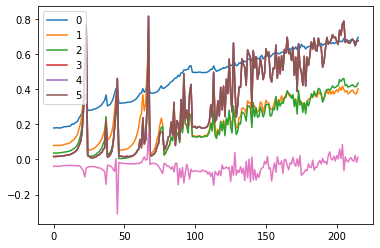

In [36]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

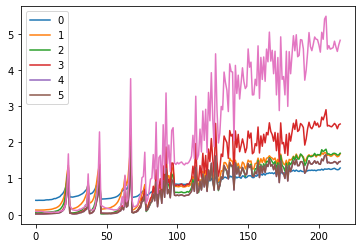

In [37]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

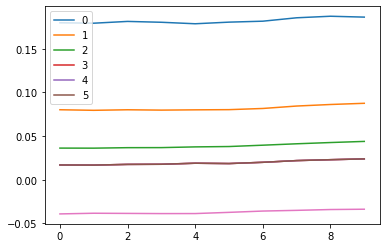

In [38]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

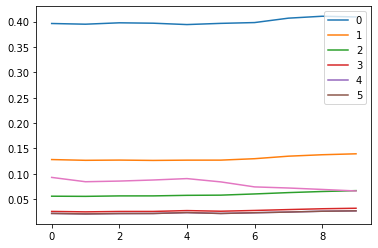

In [39]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

### Pytorch hooks
Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [40]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [41]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [42]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [43]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [44]:
run.fit(1, learn)

train: [1.87234, tensor(0.3575, device='cuda:0')]
valid: [0.52087890625, tensor(0.8454, device='cuda:0')]


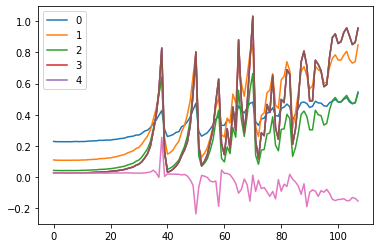

In [45]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class
We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [46]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [47]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [48]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [49]:
run.fit(1, learn)

train: [2.293374375, tensor(0.1402, device='cuda:0')]
valid: [2.2164234375, tensor(0.2055, device='cuda:0')]


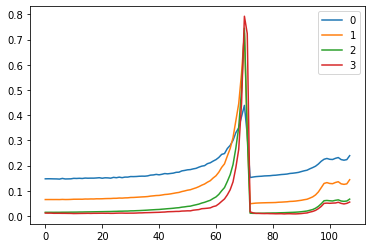

In [50]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class
Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:

- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices ([True,False,False,True,...])

The __iter__ method is there to be able to do things like for x in ....

In [51]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ ',...]'
        return res

In [52]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [53]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,...]

In [54]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a Hooks class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [55]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [56]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [57]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f6eb77776a0>, <__main__.Hook object at 0x7f6eb7777128>, <__main__.Hook object at 0x7f6eb7777cc0>, <__main__.Hook object at 0x7f6eb2e0e550>, <__main__.Hook object at 0x7f6eb2e0e7b8>, <__main__.Hook object at 0x7f6eb2e0e5c0>, <__main__.Hook object at 0x7f6eb2e0e7f0>]

In [58]:
hooks.remove()

In [59]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [60]:
x.mean(),x.std()

(tensor(-0.0048, device='cuda:0'), tensor(0.9962, device='cuda:0'))

In [61]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1385, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3458, device='cuda:0', grad_fn=<StdBackward0>))

In [62]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [63]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.6276, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8137, device='cuda:0', grad_fn=<StdBackward0>))

Having given an __enter__ and __exit__ method to our Hooks class, we can use it as a context manager. This makes sure that onces we are out of the with block, all the hooks have been removed and aren't there to pollute our memory.

train: [1.33698453125, tensor(0.5468, device='cuda:0')]
valid: [0.2515715087890625, tensor(0.9235, device='cuda:0')]
train: [0.19070857421875, tensor(0.9416, device='cuda:0')]
valid: [0.115298779296875, tensor(0.9655, device='cuda:0')]


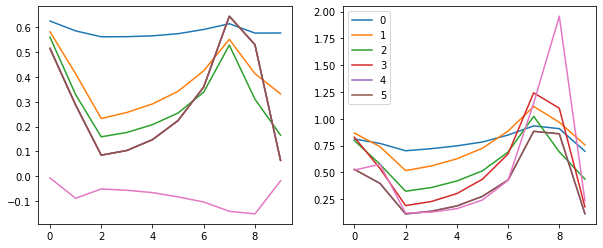

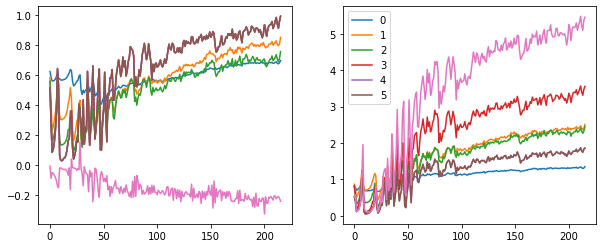

In [64]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

## Generalized ReLU

In [65]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [66]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [67]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5085730859375, tensor(0.8387, device='cuda:0')]
valid: [0.15660390625, tensor(0.9522, device='cuda:0')]


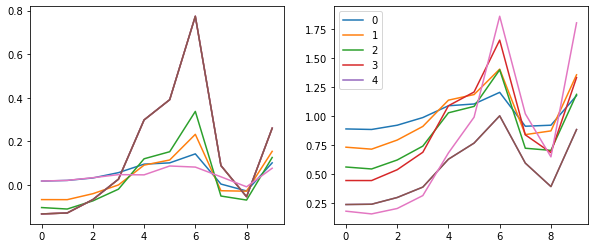

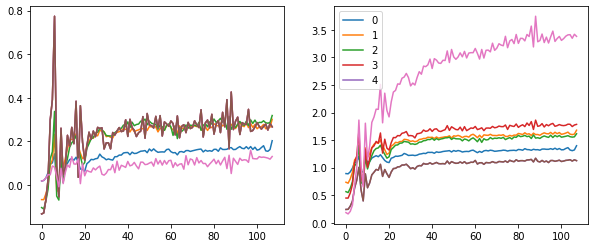

In [68]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [69]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [70]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [71]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [72]:
run.fit(8, learn)

train: [1.084851484375, tensor(0.6568, device='cuda:0')]
valid: [0.8906521484375, tensor(0.6987, device='cuda:0')]
train: [0.32125771484375, tensor(0.9053, device='cuda:0')]
valid: [0.17648355712890626, tensor(0.9481, device='cuda:0')]
train: [0.3479642578125, tensor(0.8958, device='cuda:0')]
valid: [0.1486353271484375, tensor(0.9572, device='cuda:0')]
train: [0.129375380859375, tensor(0.9617, device='cuda:0')]
valid: [0.1140867919921875, tensor(0.9682, device='cuda:0')]
train: [0.099299560546875, tensor(0.9702, device='cuda:0')]
valid: [0.07230814208984375, tensor(0.9798, device='cuda:0')]
train: [0.0591965185546875, tensor(0.9815, device='cuda:0')]
valid: [0.0682131103515625, tensor(0.9803, device='cuda:0')]
train: [0.044803173828125, tensor(0.9866, device='cuda:0')]
valid: [0.06020712890625, tensor(0.9831, device='cuda:0')]
train: [0.0370819384765625, tensor(0.9890, device='cuda:0')]
valid: [0.05882764892578125, tensor(0.9834, device='cuda:0')]


In [73]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [74]:
run.fit(8, learn)

train: [1.256631796875, tensor(0.6048, device='cuda:0')]
valid: [0.29794697265625, tensor(0.9132, device='cuda:0')]
train: [0.334178515625, tensor(0.8994, device='cuda:0')]
valid: [0.3487998779296875, tensor(0.9002, device='cuda:0')]
train: [0.31503662109375, tensor(0.9091, device='cuda:0')]
valid: [1.7329041015625, tensor(0.4703, device='cuda:0')]
train: [0.20698455078125, tensor(0.9381, device='cuda:0')]
valid: [0.1090949462890625, tensor(0.9700, device='cuda:0')]
train: [0.08379375, tensor(0.9744, device='cuda:0')]
valid: [0.07451008911132813, tensor(0.9784, device='cuda:0')]
train: [0.0598217626953125, tensor(0.9819, device='cuda:0')]
valid: [0.0666187255859375, tensor(0.9805, device='cuda:0')]
train: [0.04514048828125, tensor(0.9862, device='cuda:0')]
valid: [0.064166455078125, tensor(0.9821, device='cuda:0')]
train: [0.03734728271484375, tensor(0.9890, device='cuda:0')]
valid: [0.06415745239257813, tensor(0.9826, device='cuda:0')]


In [75]:
%%bash
python3 "../src/notebook2script.py" 05_cuda_cnn_hooks.ipynb

Converted 05_cuda_cnn_hooks.ipynb to ../src/nb_05.py
